# Прогноз оттока клиентов для оператора связи

Оператор связи "Ниединогоразрыва.ком" хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложины промокоды и успециальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг
Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. возможно подклчюение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, "цифровая абонентская линия") или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия техинческой поддержики (techSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
За услуги клиенты могут платить каждый месяц или заключить договор на 1-2 года. Доступны различные способы расчета и возможность получение электронного чека.

### Описание данных
Данные состоят из файлов, полученных из различных источинков:
- contract.csv - инфомрация о договоре;
- personal.csv - персональные данные клиента;
- internet.csv - информацию об интернет-услугах;
- phone.csv - информация об услугах телефонии.
Во всех файлах таблиц customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020 года.

## Ознакомление с данными

In [1]:
# Загружаем библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

warnings.filterwarnings('ignore')

In [2]:
# Загружаем данные
try:
    contract = pd.read_csv('contract.csv', index_col='customerID')
    personal = pd.read_csv('personal.csv', index_col='customerID')
    internet = pd.read_csv('internet.csv', index_col='customerID')
    phone = pd.read_csv('phone.csv', index_col='customerID')
except FileNotFoundError:
    contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
    personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
    internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
    phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

In [3]:
# Выводим информацию по датасетам
def info(data):
    print('Информация о формате, количестве строк и пропусках')
    print(data.info())
    print('Обзор данных')
    display(data.head(10))
    print('Статистическая информация')
    display(data.describe(include='all'))

In [4]:
# По датасету contract
info(contract)

Информация о формате, количестве строк и пропусках
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None
Обзор данных


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05


Статистическая информация


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,5,3,2,4,NaN,6531
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [5]:
# По датасету personal
info(personal)

Информация о формате, количестве строк и пропусках
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None
Обзор данных


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


Статистическая информация


,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


In [6]:
# По датасету internet
info(internet)

Информация о формате, количестве строк и пропусках
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None
Обзор данных


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


Статистическая информация


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


In [7]:
# По датасету phone
info(phone)

Информация о формате, количестве строк и пропусках
<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None
Обзор данных


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


Статистическая информация


,MultipleLines
count,6361
unique,2
top,No
freq,3390


**Вывод:** пропусков в данных нет, столбец TotalCharges содержит вещественные числа, соотвественно следует привести его к числовому формату, столбец BeginDate (дата начала сотрудничества) следует перевести в формат datetime. Т.е. в таблицах contracts и personal одинаковое количенство строк, а в остальных таблицах другое количество строк, что связано с тем, что клиент не пользуется данными услугами. При объединении датасетов, чтобы было понятно, с чем связаны пропуски в данных, необходимо у каждого клиента ввести новые столбцы пользуется ли клиент телефоном и интернетом.

## Предобработка данных

In [8]:
# Добавим признаки в соотвествующие датасеты пользуется ли клиент телефоном и интернетом
internet['internet'] = 'Yes'
phone['phone'] = 'Yes'

In [9]:
# Объединяем все датасеты в один по индексу
datasets = [contract, personal, internet, phone]
df = contract.join(datasets[1:]).reset_index()

Проверим объединенный датасет на дубликаты

In [10]:
print('Количество дубликатов', df.duplicated().sum())

Количество дубликатов 0


In [11]:
# Проверяем, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Т.к. пропуски в данных в данном случае показывают, что клиенты не пользуются теми или иными видами услуг, заменяем пропуски в данных значением 'No'

In [12]:
df = df.fillna('No')

In [13]:
# Проверяем
df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,Yes,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,Yes,No,Yes
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,...,Fiber optic,No,Yes,No,No,Yes,No,Yes,Yes,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,...,DSL,Yes,No,No,No,No,No,Yes,No,No
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,...,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes


Выведем список уникальных значений столбца TotalCharges

In [14]:
print(sorted(df['TotalCharges'].unique()))

[' ', '100.2', '100.25', '100.35', '100.4', '100.8', '100.9', '1001.2', '1001.5', '1003.05', '1004.35', '1004.5', '1004.75', '1005.7', '1006.9', '1007.8', '1007.9', '1008.55', '1008.7', '1009.25', '101.1', '101.45', '101.65', '101.9', '1010', '1011.05', '1011.5', '1011.8', '1012.4', '1013.05', '1013.2', '1013.35', '1013.6', '1014.25', '1016.7', '1017.35', '102.45', '102.5', '102.75', '1020.2', '1020.75', '1021.55', '1021.75', '1021.8', '1022.5', '1022.6', '1022.95', '1023.75', '1023.85', '1023.9', '1023.95', '1024', '1024.65', '1024.7', '1025.05', '1025.15', '1025.95', '1026.35', '1027.25', '1028.75', '1028.9', '1029.35', '1029.75', '1029.8', '103.7', '1031.1', '1031.4', '1031.7', '1032', '1032.05', '1033', '1033.9', '1033.95', '1035.5', '1035.7', '1036', '1036.75', '1037.75', '1039.45', '104.2', '104.3', '1041.8', '1042.65', '1043.3', '1043.35', '1043.4', '1043.8', '1045.25', '1046.1', '1046.2', '1046.5', '1047.7', '1048.45', '1048.85', '1049.05', '1049.6', '105.5', '105.6', '1050.5',

В столбце кроме числовых значений присутствует значение ' ', более подробно рассмотрим эти строки

In [15]:
df.loc[df['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,...,No,No,No,No,No,No,No,No,No,Yes
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,...,No,No,No,No,No,No,No,No,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,...,No,No,No,No,No,No,No,No,No,Yes
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,...,No,No,No,No,No,No,No,No,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,...,No,No,No,No,No,No,No,No,No,Yes
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,...,No,No,No,No,No,No,No,No,No,Yes
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes


У всех 11 абонентов дата подключение 01.02.2020, т.е. последняя дата датасета. Соотвественно в данном столбце у абонентов пока нет общей суммы. Т.е. никакой статистической информации у этих абонентов пока нет, удалим данные строки

In [16]:
df = df[df.TotalCharges != ' ']

Поменяем тип данных в столбцах TotalCharges и BeginDate

In [17]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

In [18]:
# Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   int64  
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   7032 non-null   object 
 13  OnlineSecurity    7032 non-null   object 
 14  OnlineBackup      7032 non-null   object 
 15  DeviceProtection  7032 non-null   object 
 16  TechSupport       7032 non-null   object 


In [19]:
# Изменим тип данных в столбце BeginDate на datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

Сравним ушедших и оставшихся клиентов, для этого разделим исходный датасет на две части

In [21]:
gone = df.loc[df['EndDate'] != 'No']
stayed = df.loc[df['EndDate'] == 'No']

Для датасета с ушедшими клентами в столбце EndDate есть все данные, поэтому изменим тип столбца EndDate на datetime и вычислим время, которое абонент пользовался услугами компании.

In [22]:
gone['EndDate'] = pd.to_datetime(gone['EndDate'])

In [23]:
# Вычислим время которое абонент пользовался услугами компании
gone['togethet'] = round((gone['EndDate'] - gone['BeginDate'])/np.timedelta64(1, 'D'))

Посмотрим статистическую информацию по датасетам отдельно по ушедшим клиентами и по всем данным

In [24]:
# Посмотрим статистическую информацию по датасету с ушедшими клиентами
gone['MonthlyCharges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [25]:
# Посмотрим статистическую информацию по всем данным
df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

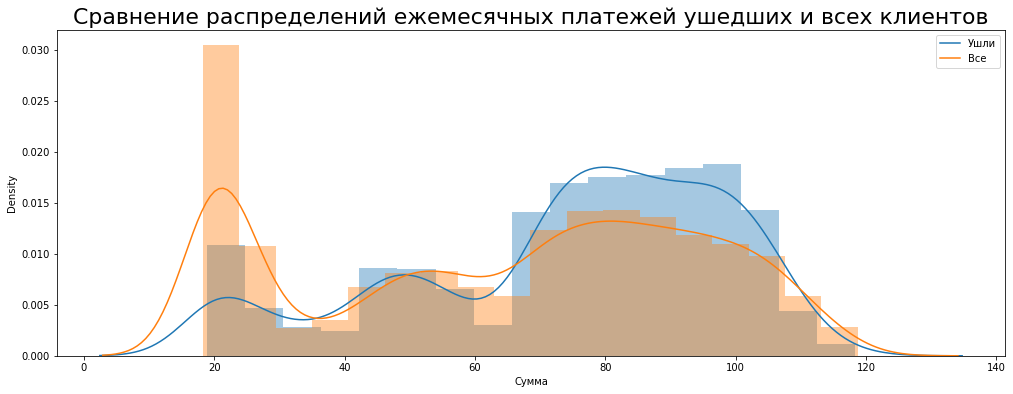

In [26]:
# Чтобы оценить построим график
fig = plt.figure(figsize=(17,6))
sns.distplot(gone['MonthlyCharges'])
sns.distplot(df['MonthlyCharges'])
plt.title('Сравнение распределений ежемесячных платежей ушедших и всех клиентов', fontsize=22)
plt.xlabel('Сумма')
plt.legend(labels=['Ушли','Все'])
plt.show()

Мы видим, что чаще уходят клиенты у которых ежемесячные траты выше. Полимодальное распределение с тремя модами позволяет предположить, что есть три базовых тарифа. Клиенты тратящие больше уходят чаще. Если тариф стоит дороже, можно преположить, что  в нем предусмотрены какие-то дополнительные услуги, которых нет в других тарифах и возможно клиенты будут и дальше пользоваться услугами компании, если им предложить перейти на другой тариф.

In [27]:
gone['togethet'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: togethet, dtype: float64

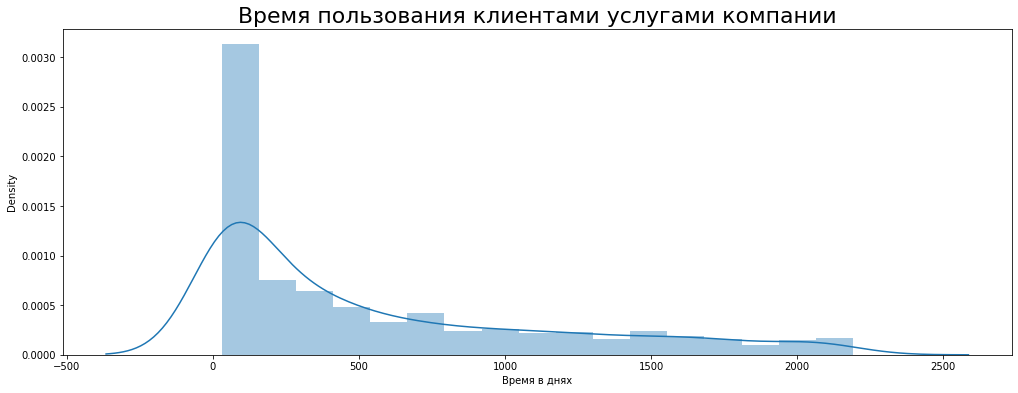

In [28]:
# Чтобы оценить построим график
fig = plt.figure(figsize=(17,6))
sns.distplot(gone['togethet'])
plt.title('Время пользования клиентами услугами компании', fontsize=22)
plt.xlabel('Время в днях')
plt.show()

Четверть уходящих клиентов, уходит в первый месяц, половина в первые 10 месяцев.

В дальнейшем нам не нужны номера клиентов, поэтому удалим их

In [29]:
df = df.drop(columns='customerID')

Так как нам нужно предсказать, уйдет клиент(признак 0) или нет (признак 1), создадим бинарный целевой признак в поле left

In [30]:
df.loc[df['EndDate'] != 'No', 'left'] = 1
df.loc[df['EndDate'] == 'No', 'left'] = 0
# Изменим тип данных на целый
df['left'] = df['left'].astype(int)

Если в поле EndDate стоит No, т.е. клиент еще пользуется услугами компании, дату окончания сотрудничества меняем на дату выгрузки датасета 01.02.2020. Меняем тип данных в данном поле на дату и высчитываем время пользования клиентом услугами компании. Далее столбцы BeginDate и EndDate больше не нужны удаляем эти столбцы. 

In [31]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['togethet'] = round((df['EndDate'] - df['BeginDate'])/np.timedelta64(1, 'D')).astype(int)
df = df.drop(columns=['EndDate', 'BeginDate'])

In [34]:
# Посмотрим общую информацию по датасету
pd.set_option('max_columns', df.columns.size)
df.describe(include='all')

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,left,togethet
count,7032,7032,7032,7032.000000,7032.000000,7032,7032.000000,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000
unique,3,2,4,NaN,NaN,2,NaN,2,2,3,2,2,2,2,2,2,2,2,2,NaN,NaN
top,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,Yes,NaN,NaN
freq,3875,4168,2365,NaN,NaN,3549,NaN,3639,4933,3096,5017,4607,4614,4992,4329,4301,5512,4065,6352,NaN,NaN
mean,NaN,NaN,NaN,64.798208,2283.300441,NaN,0.162400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.265785,987.538538
std,NaN,NaN,NaN,30.085974,2266.771362,NaN,0.368844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441782,747.153663
min,NaN,NaN,NaN,18.250000,18.800000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,30.000000
25%,NaN,NaN,NaN,35.587500,401.450000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,275.000000
50%,NaN,NaN,NaN,70.350000,1397.475000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,883.000000
75%,NaN,NaN,NaN,89.862500,3794.737500,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1676.000000


In [35]:
# Посмотрим на сам датасет
display(df.head(20))

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,left,togethet
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,No,No,0,31
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes,0,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes,1,61
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,Yes,1,61
5,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,Yes,Yes,1,245
6,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,Yes,Yes,0,671
7,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,Yes,No,No,0,306
8,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1,853
9,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes,0,1888


Данные в столбцах InternetService  и Internet очень похожи. В первом вместо Yes стоит конкретный сервис, значения No одинаковы в обоих. Я думаю стоит удалить столбец InternetService, чтобы не нагружать модель лишней информацией.

In [36]:
df = df.drop(columns=['InternetService'])

In [37]:
# Просмотрим уникальные значения в полях
def cat_type(df, col):
    print(col)
    print(df[col].unique())
    print()
    return df

In [38]:
categorial = ['Type', 'internet', 'Partner', 'DeviceProtection', 'gender', 'OnlineBackup', 'Dependents', 
              'PaperlessBilling', 'StreamingTV', 'MultipleLines', 'SeniorCitizen', 'TechSupport', 'OnlineSecurity',
              'StreamingMovies', 'PaymentMethod', 'phone']

In [39]:
for i in categorial:
    cat_type(df, i)

Type
['Month-to-month' 'One year' 'Two year']

internet
['Yes' 'No']

Partner
['Yes' 'No']

DeviceProtection
['No' 'Yes']

gender
['Female' 'Male']

OnlineBackup
['Yes' 'No']

Dependents
['No' 'Yes']

PaperlessBilling
['Yes' 'No']

StreamingTV
['No' 'Yes']

MultipleLines
['No' 'Yes']

SeniorCitizen
[0 1]

TechSupport
['No' 'Yes']

OnlineSecurity
['No' 'Yes']

StreamingMovies
['No' 'Yes']

PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

phone
['No' 'Yes']



Закодируем признаки

In [40]:
df = pd.get_dummies(df, drop_first=True).astype(int)

In [41]:
# Проверим размер датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   MonthlyCharges                         7032 non-null   int64
 1   TotalCharges                           7032 non-null   int64
 2   SeniorCitizen                          7032 non-null   int64
 3   left                                   7032 non-null   int64
 4   togethet                               7032 non-null   int64
 5   Type_One year                          7032 non-null   int64
 6   Type_Two year                          7032 non-null   int64
 7   PaperlessBilling_Yes                   7032 non-null   int64
 8   PaymentMethod_Credit card (automatic)  7032 non-null   int64
 9   PaymentMethod_Electronic check         7032 non-null   int64
 10  PaymentMethod_Mailed check             7032 non-null   int64
 11  gender_Male                   

Вычислим корреляцию между признаками MonthlyCharges и TotalCharges и togethet

<AxesSubplot:>

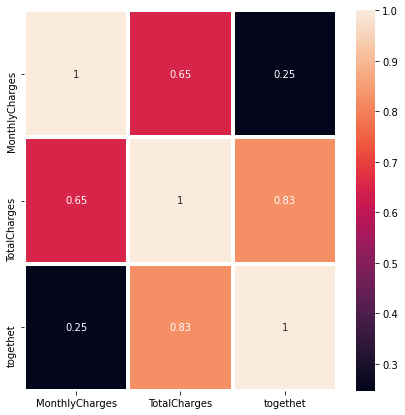

In [42]:
# Проверяем датасет на мультиколениарность
df_cor = df[['MonthlyCharges', 'TotalCharges', 'togethet']]
plt.rcParams['figure.figsize'] = (7.0, 7.0)
sns.heatmap(df_cor.corr(), annot=True, linewidths=3, linecolor='white')

Есть высокая корреляция между признаками TotalCharges и togethet  и заметная корреляция между признаками TotalCharges и  MonthlyChanges. Попробуем с помощью эксперимента выяснить при удалении какого из признаков (TotalCharges или MonthlyCharges) результат будет лучше. 

Попробуем удалить из датасета TotalChanges и посмотреть на результаты.

In [43]:
df_m = df.drop(columns=['TotalCharges'])

In [44]:
display(df_m.head(10))

,MonthlyCharges,SeniorCitizen,left,togethet,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,internet_Yes,MultipleLines_Yes,phone_Yes
0,29,0,0,31,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,56,0,0,1036,1,0,0,0,0,1,...,0,1,0,1,0,0,0,1,0,1
2,53,0,1,61,0,0,1,0,0,1,...,0,1,1,0,0,0,0,1,0,1
3,42,0,0,1371,1,0,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
4,70,0,1,61,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,1
5,99,0,1,245,0,0,1,0,1,0,...,0,0,0,1,0,1,1,1,1,1
6,89,0,0,671,0,0,1,1,0,0,...,1,0,1,0,0,1,0,1,1,1
7,29,0,0,306,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
8,104,0,1,853,0,0,1,0,1,0,...,0,0,0,1,1,1,1,1,1,1
9,56,0,0,1888,1,0,0,0,0,0,...,1,1,1,0,0,0,0,1,0,1


Проверяем баланс классов создаем список весов, для передачи в CatBoost

In [45]:
one_class_waight = df_m.loc[df_m['left'] == 1].shape[0] / df_m['left'].shape[0]
zero_class_waight = 1 - one_class_waight
class_waights = [one_class_waight, zero_class_waight]
class_waights

[0.26578498293515357, 0.7342150170648465]

Есть существенный дисбаланс классов целевого признака. Разбиваем на обучающую и тестовую выборки.

In [46]:
train, test = train_test_split(df_m, test_size=0.25, random_state = 120922, stratify = df_m['left'])

Отделяем целевой признак

In [47]:
def split_features_target(df, target):
    features = df.drop(target, axis=1)
    target = df[target]
    return features, target

In [48]:
features_test, target_test = split_features_target(test, 'left')
features_train, target_train = split_features_target(train, 'left')

## Подбор моделей

In [49]:
# Создаем таблицу для сбора метрик
models_scors = pd.DataFrame(columns = ['model', 'roc_auc'])

### RandomForestClassifier

In [50]:
%%time
RF_model = RandomForestClassifier(random_state=120922, class_weight='balanced')
parameters = [{'max_depth': [6, 7, 8], 'n_estimators': [100, 110, 120]}]
RF_model_gscv = GridSearchCV(RF_model, param_grid = parameters, scoring = 'roc_auc',
                             cv=3, verbose=True)
RF_model_gscv.fit(features_train, target_train)
models_scors = models_scors.append({'model': 'RandomForestClassifier', 'roc_auc': RF_model_gscv.best_score_}, ignore_index=True)
RF_model_gscv.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
CPU times: user 7.85 s, sys: 69 ms, total: 7.92 s
Wall time: 7.93 s


{'max_depth': 7, 'n_estimators': 110}

### CatBoostClassifier

In [51]:
%%time
CBC_model = CatBoostClassifier(random_state=120922, silent=True, class_weights=class_waights)
parameters = [{'max_depth': [1, 2, 3], 'n_estimators': [300, 400, 500], 'learning_rate':[0.4, 0.5, 0.6]}]
CBC_model_gscv = GridSearchCV(CBC_model, param_grid = parameters, scoring = 'roc_auc',
                             cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(features_train, target_train)
models_scors = models_scors.append({'model': 'CatBoostClassifier', 'roc_auc': CBC_model_gscv.best_score_}, ignore_index=True)
CBC_model_gscv.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
CPU times: user 27.8 s, sys: 2.3 s, total: 30.1 s
Wall time: 1min 26s


{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 400}

In [52]:
models_scors

,model,roc_auc
0,RandomForestClassifier,0.852459
1,CatBoostClassifier,0.925341


Попробуем удалить из датасета MonthlyCharges и посмотреть на результаты.

In [53]:
df_c = df.drop(columns=['MonthlyCharges'])

In [54]:
display(df_c.head(10))

,TotalCharges,SeniorCitizen,left,togethet,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,internet_Yes,MultipleLines_Yes,phone_Yes
0,29,0,0,31,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,1889,0,0,1036,1,0,0,0,0,1,...,0,1,0,1,0,0,0,1,0,1
2,108,0,1,61,0,0,1,0,0,1,...,0,1,1,0,0,0,0,1,0,1
3,1840,0,0,1371,1,0,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
4,151,0,1,61,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,1
5,820,0,1,245,0,0,1,0,1,0,...,0,0,0,1,0,1,1,1,1,1
6,1949,0,0,671,0,0,1,1,0,0,...,1,0,1,0,0,1,0,1,1,1
7,301,0,0,306,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
8,3046,0,1,853,0,0,1,0,1,0,...,0,0,0,1,1,1,1,1,1,1
9,3487,0,0,1888,1,0,0,0,0,0,...,1,1,1,0,0,0,0,1,0,1


In [55]:
one_class_waight = df_c.loc[df_c['left'] == 1].shape[0] / df_c['left'].shape[0]
zero_class_waight = 1 - one_class_waight
class_waights = [one_class_waight, zero_class_waight]
class_waights

[0.26578498293515357, 0.7342150170648465]

In [56]:
train, test = train_test_split(df_c, test_size=0.25, random_state = 120922, stratify = df_c['left'])

In [57]:
features_test, target_test = split_features_target(test, 'left')
features_train, target_train = split_features_target(train, 'left')

In [58]:
models_scors_c = pd.DataFrame(columns = ['model', 'roc_auc'])

In [59]:
%%time
RF_model = RandomForestClassifier(random_state=120922, class_weight='balanced')
parameters = [{'max_depth': [7, 8, 9], 'n_estimators': [100, 110, 120]}]
RF_model_gscv = GridSearchCV(RF_model, param_grid = parameters, scoring = 'roc_auc',
                             cv=3, verbose=True)
RF_model_gscv.fit(features_train, target_train)
models_scors_c = models_scors_c.append({'model': 'RandomForestClassifier', 'roc_auc': RF_model_gscv.best_score_}, ignore_index=True)
RF_model_gscv.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
CPU times: user 8.94 s, sys: 38.2 ms, total: 8.98 s
Wall time: 8.98 s


{'max_depth': 8, 'n_estimators': 120}

In [60]:
%%time
CBC_model = CatBoostClassifier(random_state=120922, silent=True, class_weights=class_waights)
parameters = [{'max_depth': [2, 3, 4], 'n_estimators': [700, 800, 900], 'learning_rate':[0.3, 0.4, 0.5]}]
CBC_model_gscv = GridSearchCV(CBC_model, param_grid = parameters, scoring = 'roc_auc',
                             cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(features_train, target_train)
models_scors_c = models_scors_c.append({'model': 'CatBoostClassifier', 'roc_auc': CBC_model_gscv.best_score_}, ignore_index=True)
CBC_model_gscv.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
CPU times: user 1min 8s, sys: 5.06 s, total: 1min 13s
Wall time: 2min 21s


{'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 800}

In [61]:
models_scors_c

,model,roc_auc
0,RandomForestClassifier,0.851240
1,CatBoostClassifier,0.919926


Лучшие результаты были получены для случая если исключить из датасета столбец TotalCharges. Лучшие результаты продемонстрировала CatBoost, будем подбирать параметры для нее.

Лучшие результаты продемонстрировала CatBoost, будем подбирать параметры для нее.

### Подбор параметров для CatBoostClassifier

In [62]:
# Воссстанавливаем параметры
one_class_waight = df_m.loc[df_m['left'] == 1].shape[0] / df_m['left'].shape[0]
zero_class_waight = 1 - one_class_waight
class_waights = [one_class_waight, zero_class_waight]
class_waights

[0.26578498293515357, 0.7342150170648465]

In [63]:
train, test = train_test_split(df_m, test_size=0.25, random_state = 120922, stratify = df_m['left'])

In [64]:
features_test, target_test = split_features_target(test, 'left')
features_train, target_train = split_features_target(train, 'left')

In [65]:
%%time
# Произведем еще раз расчет для выбранной модели
CBC_model = CatBoostClassifier(random_state=120922, silent=True, class_weights=class_waights)
parameters = [{'max_depth': [2], 'n_estimators': [400], 'learning_rate':[0.5]}]
CBC_model_gscv = GridSearchCV(CBC_model, param_grid = parameters, scoring = 'roc_auc',
                             cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(features_train, target_train)
CBC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 1.48 s, sys: 118 ms, total: 1.6 s
Wall time: 4.42 s


{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 400}

Выведем важность параметров

In [66]:
features_train_importance = pd.DataFrame({'name': features_train.columns,
                                          'importance': CBC_model_gscv.best_estimator_.feature_importances_})
features_train_importance = features_train_importance.sort_values('importance', ascending=False)
features_train_importance

,name,importance
2,togethet,78.783985
4,Type_Two year,6.830589
0,MonthlyCharges,5.690851
3,Type_One year,2.333407
7,PaymentMethod_Electronic check,1.293322
18,internet_Yes,1.013815
12,OnlineSecurity_Yes,0.525027
20,phone_Yes,0.435047
5,PaperlessBilling_Yes,0.424953
15,TechSupport_Yes,0.410479


Удалим из датасета все столбцы важность которых ставляет менее 0.3

In [67]:
df_m = df_m.drop(columns=['StreamingMovies_Yes', 'OnlineBackup_Yes', 'StreamingTV_Yes', 'MultipleLines_Yes', 'Dependents_Yes',
                          'gender_Male', 'Partner_Yes', 'PaymentMethod_Credit card (automatic)', 'DeviceProtection_Yes'])

Еще раз разобьем датасет на обучающую и тестовую выборки одберем гиперпараметры и обучим модель

In [68]:
train, test = train_test_split(df_m, test_size=0.25, random_state = 120922, stratify = df_m['left'])

In [69]:
features_test, target_test = split_features_target(test, 'left')
features_train, target_train = split_features_target(train, 'left')

In [70]:
%%time
# Произведем еще раз расчет для выбранной модели
CBC_model = CatBoostClassifier(random_state=120922, silent=True, class_weights=class_waights)
parameters = [{'max_depth': [1, 2, 3], 'n_estimators': [800, 900, 100], 'learning_rate':[0.2, 0.3, 0.4]}]
CBC_model_gscv = GridSearchCV(CBC_model, param_grid = parameters, scoring = 'roc_auc',
                             cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(features_train, target_train)
CBC_model_gscv.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
CPU times: user 39.2 s, sys: 3.51 s, total: 42.8 s
Wall time: 2min 39s


{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 900}

In [71]:
# roc_auc для выбранной модели с подобранными параметрами
CBC_model_gscv.best_score_

0.9302372302637435

## Тестирование

In [72]:
print('ROC_AUC: {:.2f}'.format(roc_auc_score(
    target_test, CBC_model_gscv.best_estimator_.predict_proba(features_test)[:, 1])))

ROC_AUC: 0.94


In [73]:
print('Accuracy: {:.2%}'.format(accuracy_score(
    target_test, CBC_model_gscv.best_estimator_.predict(features_test))))

Accuracy: 86.06%


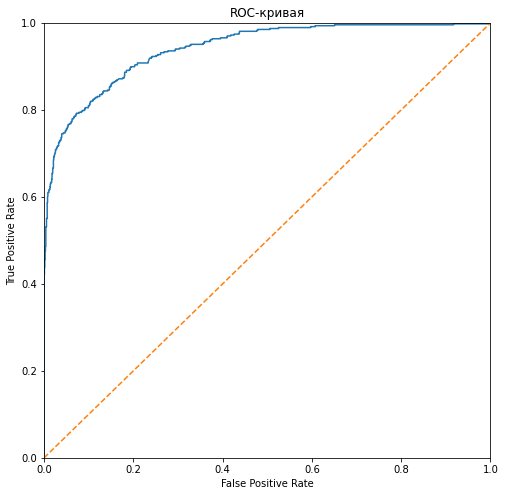

In [74]:
fpr, tpr, thresholds = roc_curve(target_test, CBC_model_gscv.best_estimator_.predict_proba(features_test)[:, 1])
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Вывод:** Наша модель модель добилась хороших результатов, площадь под ROC кривой на тестовой выборке составляет 0.94. Точность 86.07 %.
Самым важным признаком является продолжительность пользования услугами, чем дольше клиент с компанием, тем меньше вероятность, что он покинет ее. Следующим по важности признаком является, сколько в общем клиент уже заплатил компании. Чаще всего уходят клиенты с большой платой в месяц: 25 % клиентов уходит после первого месяце, 50 % в течение 10 месяцев.

## Отчет

В процессе работы была обнаружена корреляция между признаками MonthlyCharges, TotalCharges и togethet и для того, чтобы определить какое поле следует исключить из модели пришлось делать длинный расчет и сравнивать результаты. По результатам анализа было удалено поле MonthlyCharges.
Итоговая модель CatBoostClassifier с гиперпараметрами learning_rate=0.3, max_depth=2, n_estimators=900. Модель показывает AUC-ROC=0.94  и Accuracy=86.6%.
При ознакомлении с данными пропусков в данных не обнаружено, для удобства работы с датами были изменены типы полей у BeginDate и EndDate на тип дата; изменен тип данных в поле TotalCharges на вещественный.
В датасет добавлены поля internet и phone, которые позволили выявить клиентов которые пользуются интернетом или телефоном или не пользуются этими услугами. В датасет добавлено новое поле togethet в которое записана информация о времени пользования клиентом услугами компании. Удалены записи клиентов подключенных в день выгрузки датасета (таких оказалось 11 человек). При анализе датасета было принято решение об удалении поля InternetService, в котором находилась информация о способе подключения клиента к интернету, т.к. в датасет было добавлено поле internet в котором есть информация пользуется ли клиент интернетом или нет, а использование того или иного способа доступа просто будет излишне перегружать модель.
Для эффективного обучения моделей было проведено унитарное кодирование признаков.
В качестве моделей были использованы RandomForestClassifier и CatBoostClassifier. Наилучшие результаты показала модель CatBoostClassifier. С ее помощью были выявлены наиболее важные для данной задачи классификации признаки и удалены неважные, такие как: StreamingMovies_Yes, OnlineBackup_Yes, StreamingTV_Yes, MultipleLines_Yes, Dependents_Yes, gender_Male, Partner_Yes, PaymentMethod_Credit card (automatic), DeviceProtection_Yes.